In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import h5py

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Group 4/

/content/drive/.shortcut-targets-by-id/1-A7MSZ6V8eP_xZaDJ_j7yN9ddVL8-jgm/Group 4


Function to list patient names

In [ ]:
def list_patient_names(root):

    patient_list = sorted([item for item in os.listdir(root) 
                           if os.path.isdir(os.path.join(root, item))],
                           key = lambda x: x[4:])
    
    return patient_list

Function to list trial files

In [ ]:
def list_trial_files(root, patient_name):
    
    patient_folder = root + patient_name + "/"
    
    trial_names = sorted([f for f in os.listdir(patient_folder) 
                          if os.path.isfile(os.path.join(patient_folder, f))])
    
    return trial_names

Function to read in patient name, patient type, trial number, stimulus type, sensor name

In [ ]:
def parse_dat(root, patient_name, trial_file):
    
    txtfile = root + patient_name + "/" + trial_file
    
    # Read in the entire data file
    lines = []

    with gzip.open(txtfile,'rt') as f:
        for line in f:
            lines.append(line)
            
    # Get the patient name
    patient_name = lines[0].split(' ')[1][:-4]
    
    # Get patient type (alcoholic or control)
    patient_type = patient_name[3]
    
    # Get trial number
    trial_num = trial_file[-6:-3]
    
    # Get stimulus type
    stim_type = lines[3].split(' ')[1] + ' ' + lines[3].split(' ')[2]
    
    # Get sensor names
    readings = lines[4:]
    headers = [r for r in readings if r[0]=='#']
    sensor_names = [h.split(' ')[1] for h in headers]
        
    # Get sensor readings for all 64 detectors for all 256 timestamps
    data = [r for r in readings if r[0]!='#']
    
    data_mat = np.zeros((64, 256))
    
    for i in range(64):
        for j in range(256):
            data_mat[i, j] = float(data[i*256+j].split(' ')[3][:-1])
            
    return patient_name, patient_type, trial_num, stim_type, sensor_names, data_mat

Load in all the data

In [ ]:
root = os.getcwd()

In [ ]:
data_path = root + '/eeg_full/'

In [ ]:
df = pd.read_csv(data_path+'S2_match_patient_summary.csv')
hf = h5py.File(data_path+'S2_match.h5', 'r')

In [ ]:
df['Type'] = df['Type'].replace({'c':0, 'a':1})

In [ ]:
dat_tensor = np.zeros((len(df), 64, 256))

In [ ]:
dat_targets = np.zeros(len(df))

In [ ]:
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

Split training and testing data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_tensor, test_tensor, train_target, test_target = train_test_split(
                                            dat_tensor, dat_targets, test_size=0.2, random_state=0)

Construct a neural network

In [ ]:
# For constructing the neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
model = keras.models.Sequential()

model.add(layers.Conv2D(21, kernel_size=(5,20), 
                        activation='relu', 
                        input_shape=(64,256,1), 
                        bias_regularizer=regularizers.l1(1e-5),
                        activity_regularizer=regularizers.l1(1e-5),
                        kernel_regularizer=regularizers.l1(1e-5)))
model.add(layers.MaxPooling2D(pool_size=(3,12)))

model.add(layers.Flatten())
model.add(layers.Dense(13, activation='relu',
          bias_regularizer=regularizers.l1(1e-5),
          activity_regularizer=regularizers.l1(1e-5),
          kernel_regularizer=regularizers.l1(1e-5)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 237, 21)       2121      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 19, 21)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7980)              0         
                                                                 
 dense (Dense)               (None, 13)                103753    
                                                                 
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
Total params: 105,888
Trainable params: 105,888
Non-trainable params: 0
__________________________________________________

Fit the model

In [ ]:
history = model.fit(train_tensor, train_target, 
                    batch_size = 10,
                    epochs = 400,
                    validation_split=.2)

Epoch 1/400
177/177 [==============================] - 13s 15ms/step - loss: 2.8927 - binary_accuracy: 0.5981 - val_loss: 2.2008 - val_binary_accuracy: 0.6599
Epoch 2/400
177/177 [==============================] - 2s 11ms/step - loss: 2.0296 - binary_accuracy: 0.6706 - val_loss: 1.9365 - val_binary_accuracy: 0.5556
Epoch 3/400
177/177 [==============================] - 2s 11ms/step - loss: 1.7261 - binary_accuracy: 0.7058 - val_loss: 1.6358 - val_binary_accuracy: 0.6553
Epoch 4/400
177/177 [==============================] - 2s 11ms/step - loss: 1.5430 - binary_accuracy: 0.7109 - val_loss: 1.4742 - val_binary_accuracy: 0.7075
Epoch 5/400
177/177 [==============================] - 2s 10ms/step - loss: 1.4340 - binary_accuracy: 0.7268 - val_loss: 1.3928 - val_binary_accuracy: 0.7120
Epoch 6/400
177/177 [==============================] - 2s 11ms/step - loss: 1.3455 - binary_accuracy: 0.7477 - val_loss: 1.3150 - val_binary_accuracy: 0.7256
Epoch 7/400
177/177 [==============================

Evaluate performance

In [ ]:
test_target_probs = model.predict(test_tensor).flatten()

In [ ]:
c_range = np.linspace(0,1,100)

In [ ]:
# Computing the accuracies
accuracies = np.ones(len(c_range))

for i in range(len(c_range)):
    c = c_range[i]
    # Compute accuracy as before but with threshold c
    accuracies[i] = np.sum(1*(test_target_probs>c)
                           ==test_target)/len(test_target)

In [ ]:
root

'/content/drive/.shortcut-targets-by-id/1-A7MSZ6V8eP_xZaDJ_j7yN9ddVL8-jgm/Group 4'

In [ ]:
model_path = root + '/Models/S2_match/'
model_name = model_path + 'cnn_save_S2_match'
model.save(model_name)

INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1-A7MSZ6V8eP_xZaDJ_j7yN9ddVL8-jgm/Group 4/Models/S2_match/cnn_save_S2_match/assets


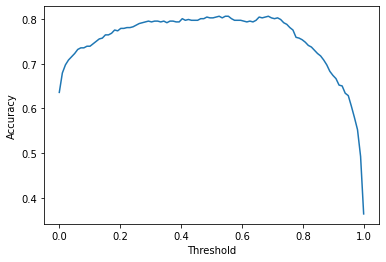

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(c_range, accuracies)
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
fig_path = root+'/Models/S2_match/S2_match-Accuracy.png'
plt.savefig(fig_path)

In [ ]:
np.max(accuracies), c_range[np.argmax(accuracies)]

(0.8061594202898551, 0.5252525252525253)

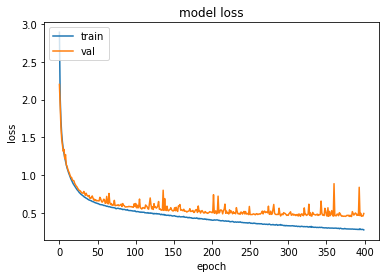

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig_path = root+'/Models/S2_match/S2_match-loss.png'
plt.savefig(fig_path)

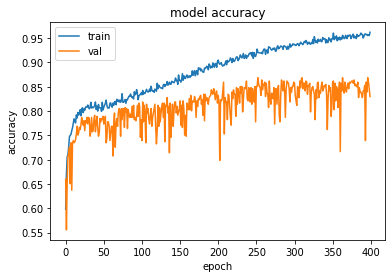

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig_path = root+'/Models/S2_match/S2_match-binary_accuracy.png'
plt.savefig(fig_path)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
preds = np.float_(test_target_probs>.5)

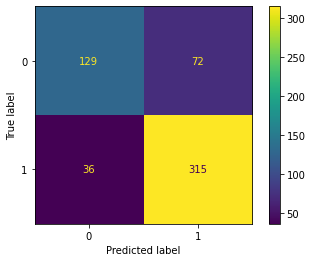

In [ ]:
# Obtain the confusion matrix
cm = confusion_matrix(y_true = test_target, 
                      y_pred = preds)

# Plot it!
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

(array([ 65.,  27.,  27.,  16.,  30.,  29.,  28.,  59.,  68., 203.]),
 array([2.6630283e-05, 1.0002397e-01, 2.0002131e-01, 3.0001864e-01,
        4.0001598e-01, 5.0001329e-01, 6.0001063e-01, 7.0000798e-01,
        8.0000532e-01, 9.0000266e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

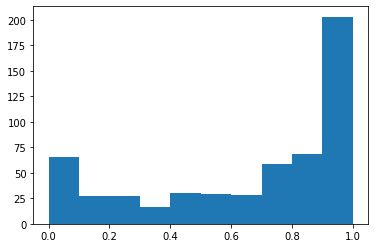

In [ ]:
plt.hist(test_target_probs)

(array([201.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 351.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

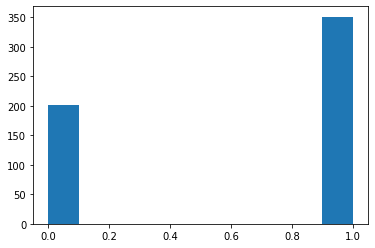

In [ ]:
plt.hist(test_target)